# <u>Welcome<u/>

### This is an attempt at the Richter's Predictor: Modeling Earthquake Damage competition, at drivendata.com.
### The goal is to predict the damage grade of a building based on its features.
### This is a great way to try out the XGBClassifier, and an interesting learning experience for large datasets

In [1]:
%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
# for preprocessing the data
from sklearn.preprocessing import StandardScaler

# the model
from sklearn.ensemble import RandomForestClassifier

# for combining the preprocess with model training
from sklearn.pipeline import make_pipeline

# for optimizing the hyperparameters of the pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score


In [2]:
train_values = pd.read_csv('train_values.csv', index_col='building_id')
train_labels = pd.read_csv('train_labels.csv', index_col='building_id')

In [3]:
train_values.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 802906 to 747594
Data columns (total 38 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   geo_level_1_id                          260601 non-null  int64 
 1   geo_level_2_id                          260601 non-null  int64 
 2   geo_level_3_id                          260601 non-null  int64 
 3   count_floors_pre_eq                     260601 non-null  int64 
 4   age                                     260601 non-null  int64 
 5   area_percentage                         260601 non-null  int64 
 6   height_percentage                       260601 non-null  int64 
 7   land_surface_condition                  260601 non-null  object
 8   foundation_type                         260601 non-null  object
 9   roof_type                               260601 non-null  object
 10  ground_floor_type                       260601 non-

In [4]:
pd.options.display.max_columns = train_values.shape[1]
train_values.describe()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
count,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000
mean,13.900353,701.074685,6257.876148,2.129723,26.535029,8.018051,5.434365,0.088645,0.761935,0.034332,0.018235,0.068154,0.075268,0.254988,0.085011,0.042590,0.015859,0.014985,0.983949,0.111880,0.064378,0.033626,0.008101,0.000940,0.000361,0.001071,0.000188,0.000146,0.000088,0.005119
std,8.033617,412.710734,3646.369645,0.727665,73.565937,4.392231,1.918418,0.284231,0.425900,0.182081,0.133800,0.252010,0.263824,0.435855,0.278899,0.201931,0.124932,0.121491,0.418389,0.315219,0.245426,0.180265,0.089638,0.030647,0.018989,0.032703,0.013711,0.012075,0.009394,0.071364
min,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,350.000000,3073.000000,2.000000,10.000000,5.000000,4.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,12.000000,702.000000,6270.000000,2.000000,15.000000,7.000000,5.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,21.000000,1050.000000,9412.000000,2.000000,30.000000,9.000000,6.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,30.000000,1427.000000,12567.000000,9.000000,995.000000,100.000000,32.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


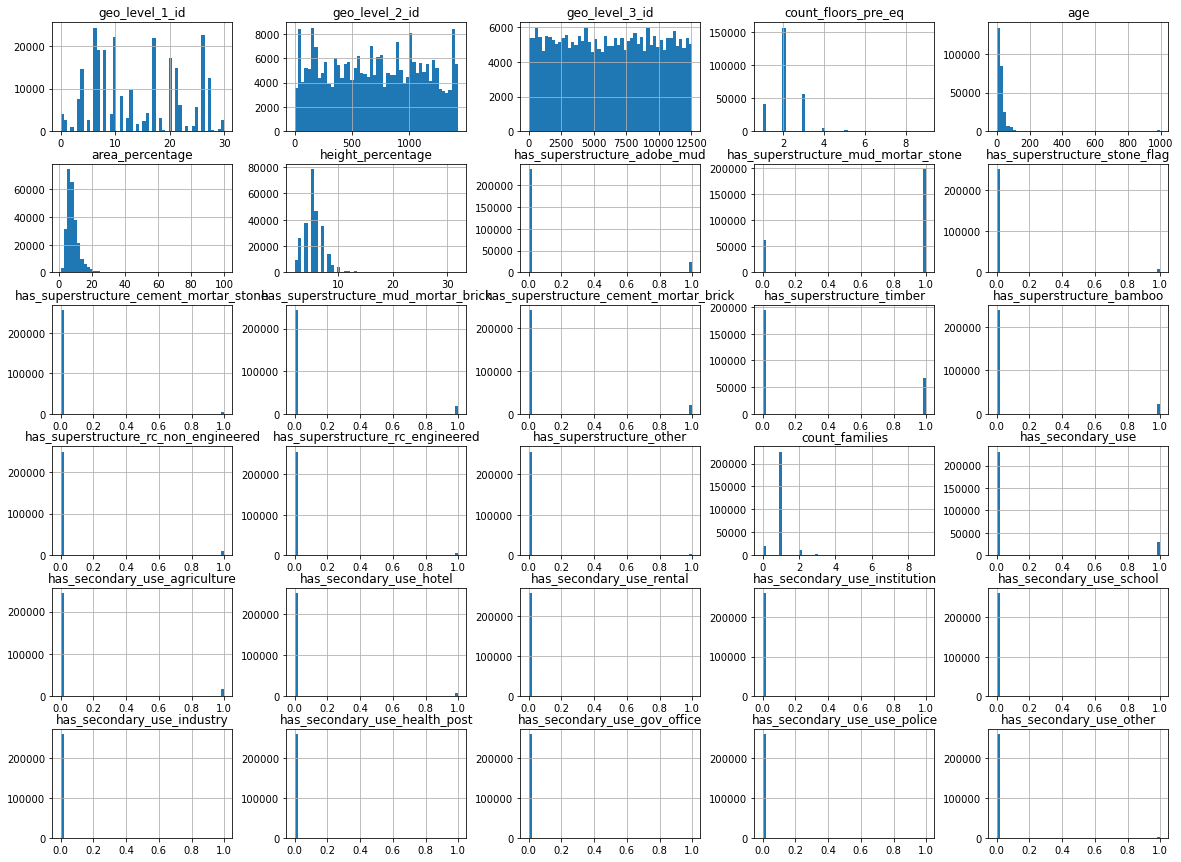

In [5]:
train_values.hist(bins=50, figsize=(20,15)) 
plt.show()

In [6]:
df=pd.merge(train_values, train_labels, on='building_id')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 802906 to 747594
Data columns (total 39 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   geo_level_1_id                          260601 non-null  int64 
 1   geo_level_2_id                          260601 non-null  int64 
 2   geo_level_3_id                          260601 non-null  int64 
 3   count_floors_pre_eq                     260601 non-null  int64 
 4   age                                     260601 non-null  int64 
 5   area_percentage                         260601 non-null  int64 
 6   height_percentage                       260601 non-null  int64 
 7   land_surface_condition                  260601 non-null  object
 8   foundation_type                         260601 non-null  object
 9   roof_type                               260601 non-null  object
 10  ground_floor_type                       260601 non-

In [8]:
for col in ['legal_ownership_status', 'plan_configuration', 'position', 'other_floor_type','ground_floor_type','roof_type','foundation_type','land_surface_condition']:
    df[col] = df[col].astype('category')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 802906 to 747594
Data columns (total 39 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   geo_level_1_id                          260601 non-null  int64   
 1   geo_level_2_id                          260601 non-null  int64   
 2   geo_level_3_id                          260601 non-null  int64   
 3   count_floors_pre_eq                     260601 non-null  int64   
 4   age                                     260601 non-null  int64   
 5   area_percentage                         260601 non-null  int64   
 6   height_percentage                       260601 non-null  int64   
 7   land_surface_condition                  260601 non-null  category
 8   foundation_type                         260601 non-null  category
 9   roof_type                               260601 non-null  category
 10  ground_floor_type          

In [10]:
#features I could argue are redundant/irrelevant
df = df.drop(['has_secondary_use', 'legal_ownership_status', 'count_families', 'has_secondary_use_rental'], axis=1)

In [11]:
df.describe()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
count,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000
mean,13.900353,701.074685,6257.876148,2.129723,26.535029,8.018051,5.434365,0.088645,0.761935,0.034332,0.018235,0.068154,0.075268,0.254988,0.085011,0.042590,0.015859,0.014985,0.064378,0.033626,0.000940,0.000361,0.001071,0.000188,0.000146,0.000088,0.005119,2.238272
std,8.033617,412.710734,3646.369645,0.727665,73.565937,4.392231,1.918418,0.284231,0.425900,0.182081,0.133800,0.252010,0.263824,0.435855,0.278899,0.201931,0.124932,0.121491,0.245426,0.180265,0.030647,0.018989,0.032703,0.013711,0.012075,0.009394,0.071364,0.611814
min,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,7.000000,350.000000,3073.000000,2.000000,10.000000,5.000000,4.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,12.000000,702.000000,6270.000000,2.000000,15.000000,7.000000,5.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,21.000000,1050.000000,9412.000000,2.000000,30.000000,9.000000,6.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,30.000000,1427.000000,12567.000000,9.000000,995.000000,100.000000,32.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000


In [12]:
#age & area_percentage seem fishy

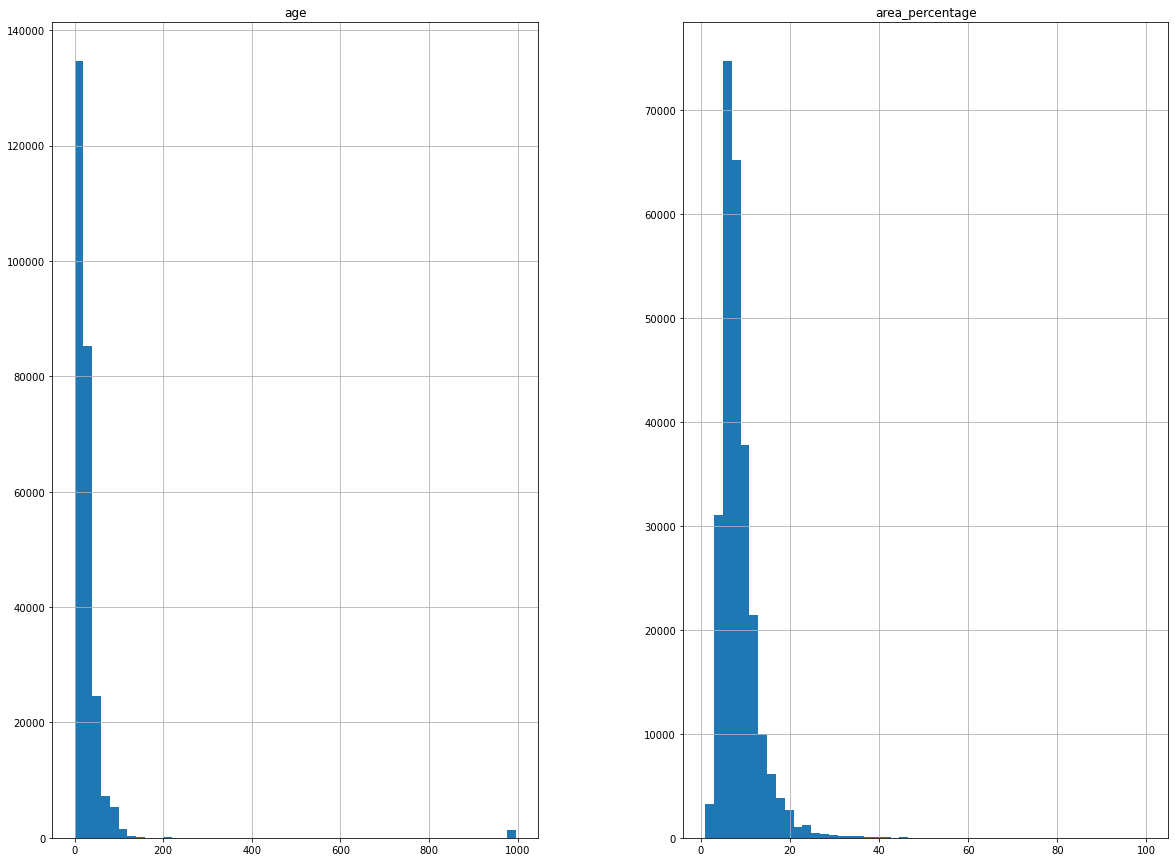

In [13]:
df[['age','area_percentage']].hist(bins=50, figsize=(20,15)) 
plt.show()

In [14]:
df[['age','area_percentage']].describe()

,age,area_percentage
count,260601.000000,260601.000000
mean,26.535029,8.018051
std,73.565937,4.392231
min,0.000000,1.000000
25%,10.000000,5.000000
50%,15.000000,7.000000
75%,30.000000,9.000000
max,995.000000,100.000000


In [15]:
df[['age','area_percentage']].sort_values(by=['age','area_percentage'], ascending=False)

,age,area_percentage
building_id,,
155009,995,34
769473,995,34
333924,995,34
810018,995,34
364452,995,31
...,...,...
753892,0,1
696388,0,1
529907,0,1


In [16]:
df.drop(df[df['age'] >= 240].index, inplace = True)

In [17]:
df.shape

(259211, 35)

In [18]:
df[['age','area_percentage']].sort_values(by=['age','area_percentage'], ascending=False)

,age,area_percentage
building_id,,
538437,200,38
39029,200,29
999127,200,25
612379,200,25
44346,200,25
...,...,...
753892,0,1
696388,0,1
529907,0,1


In [19]:
df.drop(df[df['age'] >= 200].index, inplace = True)

<AxesSubplot:>

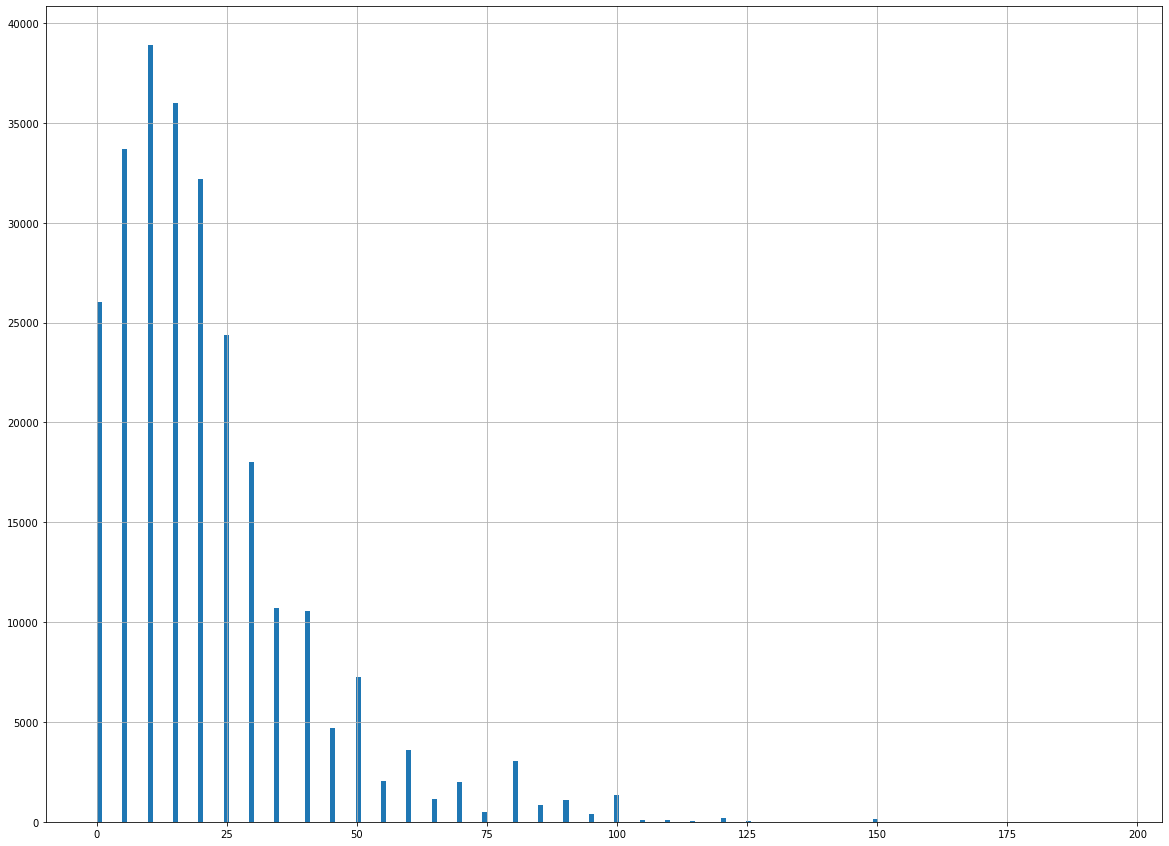

In [20]:
df['age'].hist(bins=200, figsize=(20,15))

<AxesSubplot:>

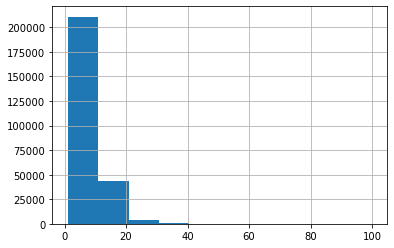

In [21]:
df['area_percentage'].hist()

In [22]:
#area_percentage (type: int): normalized area of the building footprint.
#height_percentage (type: int): normalized height of the building footprint.

In [23]:
df.index.nunique('building_id')

259105

In [24]:
df.shape

(259105, 35)

In [27]:
df.isnull().sum().sum()

0

In [28]:
corr_matrix = df.corr()
corr_matrix["damage_grade"].sort_values(ascending=False)

damage_grade                              1.000000
has_superstructure_mud_mortar_stone       0.291777
age                                       0.150381
count_floors_pre_eq                       0.123036
has_superstructure_stone_flag             0.066615
has_superstructure_adobe_mud              0.055910
height_percentage                         0.048482
geo_level_2_id                            0.042819
has_superstructure_mud_mortar_brick       0.014741
has_secondary_use_agriculture             0.010675
geo_level_3_id                            0.007901
has_secondary_use_use_police             -0.001667
has_secondary_use_health_post            -0.008578
has_secondary_use_gov_office             -0.009414
has_secondary_use_industry               -0.011079
has_secondary_use_school                 -0.011740
has_secondary_use_other                  -0.016285
has_secondary_use_institution            -0.028639
has_superstructure_other                 -0.029902
has_superstructure_cement_morta

In [29]:
#has_secondary_use_ columns will be removed. Including the hotel one since, if u think about it, it's redundant
#a hotel is very likely to have a large area, age(since hotels are built on prime locations), floor count, 
#concrete or reinforced concrete

In [30]:
df = df.drop(['has_secondary_use_use_police',
              'has_secondary_use_health_post', 'has_secondary_use_gov_office',
              'has_secondary_use_industry','has_secondary_use_school',
             'has_secondary_use_other','has_secondary_use_institution', 'has_secondary_use_agriculture',
             'geo_level_3_id', 'has_secondary_use_hotel'], axis=1)

In [31]:
corr_matrix = df.corr()
corr_matrix["damage_grade"].sort_values(ascending=False)

damage_grade                              1.000000
has_superstructure_mud_mortar_stone       0.291777
age                                       0.150381
count_floors_pre_eq                       0.123036
has_superstructure_stone_flag             0.066615
has_superstructure_adobe_mud              0.055910
height_percentage                         0.048482
geo_level_2_id                            0.042819
has_superstructure_mud_mortar_brick       0.014741
has_superstructure_other                 -0.029902
has_superstructure_cement_mortar_stone   -0.060600
has_superstructure_bamboo                -0.062358
has_superstructure_timber                -0.069001
geo_level_1_id                           -0.072183
area_percentage                          -0.124952
has_superstructure_rc_non_engineered     -0.158444
has_superstructure_rc_engineered         -0.179327
has_superstructure_cement_mortar_brick   -0.254598
Name: damage_grade, dtype: float64

## Time for some feature engineering

In [33]:
df['age'].unique()

array([ 30,  10,  25,   0,  15,  20,  45,  55,   5,  40,  80,  60,  35,
        70,  50,  65, 100,  75,  85, 190, 105,  90, 120,  95, 110, 115,
       150, 130, 125, 140, 155, 160, 175, 135, 145, 195, 180, 165, 170,
       185])

In [34]:
df['age_log'] = np.log(df['age'] + 10)

<AxesSubplot:>

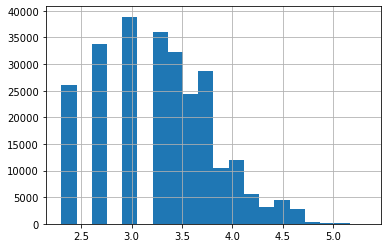

In [35]:
df['age_log'].hist(bins=20)

In [36]:
df['area_log'] = np.log(df['area_percentage'] + 10)

<AxesSubplot:>

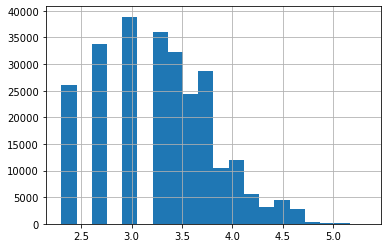

In [37]:
df['age_log'].hist(bins=20)

In [38]:
df = df.drop(['area_percentage',
              'age'], axis=1)

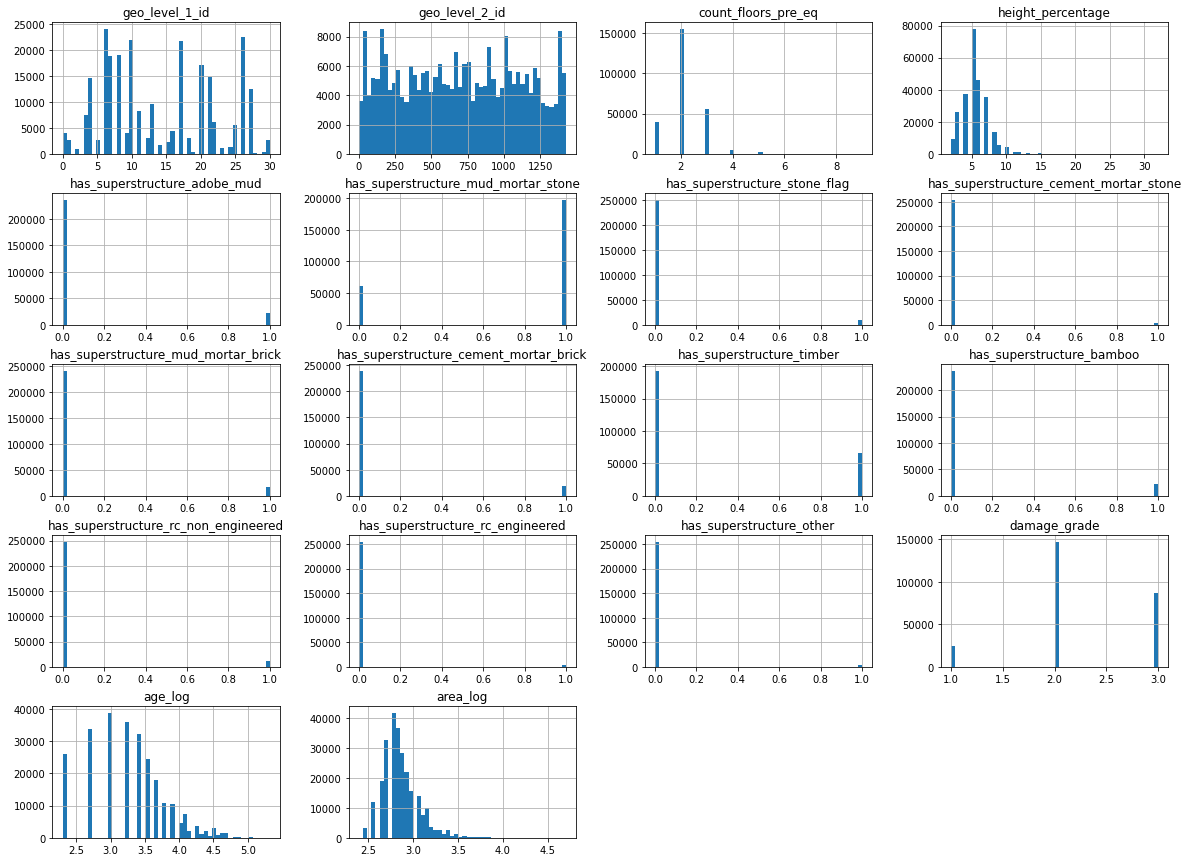

In [39]:
df.hist(bins=50, figsize=(20,15)) 
plt.show()

In [40]:
df.columns

Index(['geo_level_1_id', 'geo_level_2_id', 'count_floors_pre_eq',
       'height_percentage', 'land_surface_condition', 'foundation_type',
       'roof_type', 'ground_floor_type', 'other_floor_type', 'position',
       'plan_configuration', 'has_superstructure_adobe_mud',
       'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other',
       'damage_grade', 'age_log', 'area_log'],
      dtype='object')

In [41]:
print(df.dtypes)

geo_level_1_id                               int64
geo_level_2_id                               int64
count_floors_pre_eq                          int64
height_percentage                            int64
land_surface_condition                    category
foundation_type                           category
roof_type                                 category
ground_floor_type                         category
other_floor_type                          category
position                                  category
plan_configuration                        category
has_superstructure_adobe_mud                 int64
has_superstructure_mud_mortar_stone          int64
has_superstructure_stone_flag                int64
has_superstructure_cement_mortar_stone       int64
has_superstructure_mud_mortar_brick          int64
has_superstructure_cement_mortar_brick       int64
has_superstructure_timber                    int64
has_superstructure_bamboo                    int64
has_superstructure_rc_non_engin

In [48]:
df=pd.get_dummies(data=df, columns=['land_surface_condition', 'foundation_type',
                                 'roof_type', 'ground_floor_type',
                                 'other_floor_type', 'position',
                                 'plan_configuration'])

In [49]:
df1 = df.pop('damage_grade') # move damage_grade to last
df['damage_grade']=df1

df.columns

Index(['geo_level_1_id', 'geo_level_2_id', 'count_floors_pre_eq',
       'height_percentage', 'has_superstructure_adobe_mud',
       'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other',
       'age_log', 'area_log', 'land_surface_condition_n',
       'land_surface_condition_o', 'land_surface_condition_t',
       'foundation_type_h', 'foundation_type_i', 'foundation_type_r',
       'foundation_type_u', 'foundation_type_w', 'roof_type_n', 'roof_type_q',
       'roof_type_x', 'ground_floor_type_f', 'ground_floor_type_m',
       'ground_floor_type_v', 'ground_floor_type_x', 'ground_floor_type_z',
       'other_floor_type_j', 'other_floor_type_q', 'other_flo

In [50]:
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score #f1_score(y_test, y_pred, average='micro')

In [51]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.25)

In [53]:
xgb = XGBClassifier(booster='gbtree', objective='multi:softprob', enable_categorical=True,
                    learning_rate=0.1, n_estimators=100, random_state=2, n_jobs=-1)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
score = f1_score(y_test, y_pred, average='micro')
print('Score: ' + str(score))

[10:43:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:541: 
Parameters: { enable_categorical } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:43:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Score: 0.7018231779798385


## With default settings & unstratified method, we achieved the Score: 0.7018231779798385 !

In [57]:
model = XGBClassifier(booster='gbtree', random_state=2)

#Cross Validated sample groups perform similarly to our stratified ones, since we stratified earlier during splitting

In [59]:
# Import cross_val_score
from sklearn.model_selection import cross_val_score

# Import numpy
import numpy as np

# Obtain scores of cross-validation
scores = cross_val_score(model, X, y, cv=5)

# Display accuracy
print('Accuracy:', np.round(scores, 2))

# Display mean accuracy
print('Accuracy mean: %0.2f' % (scores.mean()))


    # Import StratifiedKFold
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)

# Obtain scores of cross-validation
scores = cross_val_score(model, X, y, cv=kfold)

# Display accuracy
print('Accuracy:', np.round(scores, 2))

# Display mean accuracy
print('Accuracy mean: %0.2f' % (scores.mean()))




/opt/anaconda3/envs/dspwp2/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:48:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:49:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:49:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:50:33] WARNING: /Users/runner/miniforge3/c

/opt/anaconda3/envs/dspwp2/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:51:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:52:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:53:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:53:46] WARNING: /Users/runner/miniforge3/c

In [62]:
# Import GridSearchCV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)

def grid_search(params, random=False): 
    
    xgb = XGBClassifier(booster='gbtree', objective='multi:softprob', random_state=2)
    
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
    
    if random:
        grid = RandomizedSearchCV(xgb, params, cv=kfold, n_iter=20, n_jobs=-1, random_state=2)
    else:
        # Instantiate GridSearchCV as grid_reg
        grid = GridSearchCV(xgb, params, cv=kfold, n_jobs=-1)
    
    # Fit grid_reg on X_train and y_train
    grid.fit(X, y)

    # Extract best params
    best_params = grid.best_params_

    # Print best params
    print("Best params:", best_params)
    
    # Compute best score
    best_score = grid.best_score_

    # Print best score
    print("Best score: {:.5f}".format(best_score))
    
    #Our function can now be used to tune the hyperparameters

## Time for hyperparameter tuning

In [63]:
grid_search(params={'n_estimators':[100, 200, 400, 800]})

[09:01:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:05:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/dspwp2/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:01:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:10:21] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/dspwp2/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:01:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:10:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/dspwp2/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/dspwp2/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:01:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:10:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/dspwp2/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:49:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:01:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:05:41] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:15:25] WARNING: /Users/runner/miniforge3/c

/opt/anaconda3/envs/dspwp2/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:01:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:05:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:15:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/dspwp2/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:01:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:05:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:27:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/dspwp2/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Best params: {'n_estimators': 400}
Best score: 0.73307


In [64]:
grid_search(params={'learning_rate':[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]})

/opt/anaconda3/envs/dspwp2/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:26:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best params: {'learning_rate': 0.5}
Best score: 0.72803


In [65]:
grid_search(params={'max_depth':[2, 3, 5, 6, 8]})

/opt/anaconda3/envs/dspwp2/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:44:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:54:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:09:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:14:23] WARNING: /Users/runner/miniforge3/c

/opt/anaconda3/envs/dspwp2/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Best params: {'max_depth': 8}
Best score: 0.72981


In [66]:
grid_search(params={'gamma':[0, 0.01, 0.1, 0.5, 1, 2]})

[09:54:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:09:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:14:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:19:20] WARNING: /Users/runner/miniforge3/c

/opt/anaconda3/envs/dspwp2/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/dspwp2/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:17:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best params: {'gamma': 1}
Best score: 0.72356


In [67]:
grid_search(params={'min_child_weight':[1, 2, 3, 4, 5]})

/opt/anaconda3/envs/dspwp2/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:32:05] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best params: {'min_child_weight': 5}
Best score: 0.72331


In [68]:
grid_search(params={'subsample':[0.5, 0.7, 0.8, 0.9, 1]})

/opt/anaconda3/envs/dspwp2/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:48:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best params: {'subsample': 0.9}
Best score: 0.72383


In [69]:
grid_search(params={'colsample_bytree':[0.5, 0.7, 0.8, 0.9, 1]})

/opt/anaconda3/envs/dspwp2/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:03:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best params: {'colsample_bytree': 0.8}
Best score: 0.72299


In [71]:
#Now we are thinking about the optimal number of trees and early stopping rounds.
#early_stopping_rounds parameter stops the algorithm from digging deeper and therefore overfitting,
#when the number of selected rounds(100 here), failed to improve predictive accuracy.

In [75]:
# Import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

model = XGBClassifier(random_state=2, n_estimators=5000)
eval_set = [(X_test, y_test)]
eval_metric="merror"
model.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, early_stopping_rounds=100)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[0]	validation_0-merror:0.34466
[1]	validation_0-merror:0.33439
[2]	validation_0-merror:0.32204
[3]	validation_0-merror:0.32186
[4]	validation_0-merror:0.32105
[5]	validation_0-merror:0.32127
[6]	validation_0-merror:0.32041
[7]	validation_0-merror:0.31982
[8]	validation_0-merror:0.31916
[9]	validation_0-merror:0.31831
[10]	validation_0-merror:0.31684
[11]	validation_0-merror:0.31594
[12]	validation_0-merror:0.31587
[13]	validation_0-merror:0.31480
[14]	validation_0-merror:0.31260
[15]	validation_0-merror:0.31196
[16]	validation_0-merror:0.31113
[17]	validation_0-merror:0.31088
[18]	validation_0-merror:0.31040
[19]	validation_0-merror:0.30946
[20]	validation_0-merror:0.30835
[21]	validation_0-merror:0.30759
[22]	validation_0-merror:0.30633
[23]	validation_0-merror:0.30528
[24]	validation_0-merror:0.30494
[25]	validation_0-merror:0.30464
[26]	validation_0-merror:0.30412
[27]	validation_0-merror:0.30350
[28]	validation_0-merror:0.30329
[29]	validation_0-merror:0.30219
[30]	validation_0-me

[245]	validation_0-merror:0.27030
[246]	validation_0-merror:0.27030
[247]	validation_0-merror:0.27014
[248]	validation_0-merror:0.27006
[249]	validation_0-merror:0.27010
[250]	validation_0-merror:0.27014
[251]	validation_0-merror:0.26996
[252]	validation_0-merror:0.26989
[253]	validation_0-merror:0.26989
[254]	validation_0-merror:0.26986
[255]	validation_0-merror:0.26991
[256]	validation_0-merror:0.26999
[257]	validation_0-merror:0.27000
[258]	validation_0-merror:0.26976
[259]	validation_0-merror:0.26976
[260]	validation_0-merror:0.26986
[261]	validation_0-merror:0.26985
[262]	validation_0-merror:0.26982
[263]	validation_0-merror:0.26977
[264]	validation_0-merror:0.26968
[265]	validation_0-merror:0.26962
[266]	validation_0-merror:0.26956
[267]	validation_0-merror:0.26934
[268]	validation_0-merror:0.26932
[269]	validation_0-merror:0.26932
[270]	validation_0-merror:0.26928
[271]	validation_0-merror:0.26931
[272]	validation_0-merror:0.26942
[273]	validation_0-merror:0.26926
[274]	validati

[486]	validation_0-merror:0.26764
[487]	validation_0-merror:0.26772
[488]	validation_0-merror:0.26773
[489]	validation_0-merror:0.26749
[490]	validation_0-merror:0.26744
[491]	validation_0-merror:0.26747
[492]	validation_0-merror:0.26760
[493]	validation_0-merror:0.26767
[494]	validation_0-merror:0.26770
[495]	validation_0-merror:0.26775
[496]	validation_0-merror:0.26763
[497]	validation_0-merror:0.26770
[498]	validation_0-merror:0.26775
[499]	validation_0-merror:0.26773
[500]	validation_0-merror:0.26784
[501]	validation_0-merror:0.26773
[502]	validation_0-merror:0.26775
[503]	validation_0-merror:0.26783
[504]	validation_0-merror:0.26775
[505]	validation_0-merror:0.26769
[506]	validation_0-merror:0.26781
[507]	validation_0-merror:0.26778
[508]	validation_0-merror:0.26778
[509]	validation_0-merror:0.26772
[510]	validation_0-merror:0.26761
[511]	validation_0-merror:0.26761
[512]	validation_0-merror:0.26753
[513]	validation_0-merror:0.26763
[514]	validation_0-merror:0.26769
[515]	validati

In [76]:
#Cross validation isn't used above, thus we expect to get different optimal parameters than before.
#We will be trying out each hyperparameter range seperately, 
#instead of bundling them all together through RandomizedSearchCV

In [77]:
grid_search(params={'n_estimators':[2, 25, 50, 75, 100]})

/opt/anaconda3/envs/dspwp2/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:17:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best params: {'n_estimators': 100}
Best score: 0.72241


In [78]:
grid_search(params={'max_depth':[1, 2, 3, 4, 6, 7, 8], 
                    'n_estimators':[50]})

/opt/anaconda3/envs/dspwp2/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:26:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best params: {'max_depth': 8, 'n_estimators': 50}
Best score: 0.72251


In [79]:
grid_search(params={'max_depth':[1, 2, 3, 4, 6, 7, 8], 
                    'n_estimators':[2, 50, 100]})

[16:09:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:10:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:13:19] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:17:59] WARNING: /Users/runner/miniforge3/c

/opt/anaconda3/envs/dspwp2/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/dspwp2/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:00:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best params: {'max_depth': 8, 'n_estimators': 100}
Best score: 0.72981


In [85]:
#Since max_depth and n_estimators are dependent on one another, it's a good idea to also test them together

In [91]:
grid_search(params={'learning_rate':[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5], 
                    'max_depth':[8], 
                    'n_estimators':[100]})

/opt/anaconda3/envs/dspwp2/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:54:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best params: {'learning_rate': 0.4, 'max_depth': 8, 'n_estimators': 100}
Best score: 0.73202


In [92]:
grid_search(params={'min_child_weight':[1, 2, 3, 4, 5], 
                    'max_depth':[8], 
                    'n_estimators':[100]})

/opt/anaconda3/envs/dspwp2/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:18:01] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best params: {'max_depth': 8, 'min_child_weight': 3, 'n_estimators': 100}
Best score: 0.73056


In [93]:
grid_search(params={'max_delta_step':[1, 3, 5, 7], 
                    'max_depth':[8], 
                    'n_estimators':[100]})

/opt/anaconda3/envs/dspwp2/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:38:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best params: {'max_delta_step': 3, 'max_depth': 8, 'n_estimators': 100}
Best score: 0.73000


In [94]:
grid_search(params={'subsample':[0.5, 0.6, 0.7, 0.8, 0.9, 1],
                    'max_depth':[8], 
                    'n_estimators':[10]})

/opt/anaconda3/envs/dspwp2/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:42:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best params: {'max_depth': 8, 'n_estimators': 10, 'subsample': 0.6}
Best score: 0.69794


In [95]:
grid_search(params={'subsample':[0.5, 0.6, 0.7, 0.8, 0.9, 1], 
                    'min_child_weight':[1, 2, 3, 4, 5], 
                    'learning_rate':[0.1, 0.2, 0.3, 0.4, 0.5], 
                    'max_depth':[1, 2, 3, 4, 5], 
                    'n_estimators':[10]})

[18:19:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:28:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:35:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:42:42] WARNING: /Users/runner/miniforge3/c

[20:36:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.[18:19:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:27:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:35:37] WARNING: /Users/runner/miniforge3/co

[20:36:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.[18:19:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:28:02] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:35:27] WARNING: /Users/runner/miniforge3/co

[20:36:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.[18:19:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:28:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:35:29] WARNING: /Users/runner/miniforge3/co

[20:36:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.[18:19:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:28:02] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:35:30] WARNING: /Users/runner/miniforge3/co

[20:36:36] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.[18:19:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:27:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:35:36] WARNING: /Users/runner/miniforge3/co

[20:37:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.[18:19:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:28:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:35:17] WARNING: /Users/runner/miniforge3/co

[20:37:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:36:37] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:37:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:37:28] WARNING: /Users/runner/miniforge3/c

[21:25:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:37:19] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:37:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:38:13] WARNING: /Users/runner/miniforge3/c

[21:26:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:36:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:37:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:37:35] WARNING: /Users/runner/miniforge3/c

[21:26:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:37:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:38:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:38:38] WARNING: /Users/runner/miniforge3/c

[21:27:01] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:36:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:37:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:37:56] WARNING: /Users/runner/miniforge3/c

[21:27:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:36:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:36:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:37:14] WARNING: /Users/runner/miniforge3/c

[21:27:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:37:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:38:01] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:38:28] WARNING: /Users/runner/miniforge3/c

[21:26:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:36:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:36:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:37:14] WARNING: /Users/runner/miniforge3/c

/opt/anaconda3/envs/dspwp2/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:04:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best params: {'learning_rate': 0.5, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 10, 'subsample': 0.7}
Best score: 0.68244


In [96]:
grid_search(params={'subsample':[0.5, 0.6, 0.7, 0.8, 0.9, 1], 
                    'min_child_weight':[1, 2, 3, 4, 5], 
                    'learning_rate':[0.1, 0.2, 0.3, 0.4, 0.5], 
                    'max_depth':[1, 2, 3, 4, 5, None], 
                    'n_estimators':[2, 25, 50, 75, 100]}, random=True)

/opt/anaconda3/envs/dspwp2/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:21:54] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best params: {'subsample': 0.6, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': None, 'learning_rate': 0.3}
Best score: 0.72344

[21:27:37] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:27:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'm

/opt/anaconda3/envs/dspwp2/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[21:26:55] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:27:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:27:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:28:00] WARNING: /Users/runner/miniforge3/

/opt/anaconda3/envs/dspwp2/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[21:26:05] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:26:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:26:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:27:11] WARNING: /Users/runner/miniforge3/

/opt/anaconda3/envs/dspwp2/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[21:27:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:27:29] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:27:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:28:13] WARNING: /Users/runner/miniforge3/

/opt/anaconda3/envs/dspwp2/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[21:27:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:28:02] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:28:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:28:46] WARNING: /Users/runner/miniforge3/

/opt/anaconda3/envs/dspwp2/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[21:27:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:27:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:28:05] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:28:27] WARNING: /Users/runner/miniforge3/

/opt/anaconda3/envs/dspwp2/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/dspwp2/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[21:27:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:27:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:28:04] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:28:26] WARNING: /Users/runner/miniforge3/


[21:27:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:27:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:27:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:28:16] WARNING: /Users/runner/miniforge3/

/opt/anaconda3/envs/dspwp2/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [97]:
grid_search(params={'colsample_bytree':[0.5, 0.6, 0.7, 0.8, 0.9, 1],
                    'max_depth':[None], 
                    'n_estimators':[150]})

/opt/anaconda3/envs/dspwp2/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[07:52:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:32:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:36:42] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:41:37] WARNING: /Users/runner/miniforge3/c

/opt/anaconda3/envs/dspwp2/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[07:32:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:36:42] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:41:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/dspwp2/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Best params: {'colsample_bytree': 0.8, 'max_depth': None, 'n_estimators': 150}
Best score: 0.72790


In [98]:
grid_search(params={'colsample_bylevel':[0.5, 0.6, 0.7, 0.8, 0.9, 1],
                    'max_depth':[None], 
                    'n_estimators':[250]})

[07:32:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:36:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:41:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:47:28] WARNING: /Users/runner/miniforge3/c

/opt/anaconda3/envs/dspwp2/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[07:53:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:01:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:13:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/dspwp2/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/dspwp2/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:38:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best params: {'colsample_bylevel': 1, 'max_depth': None, 'n_estimators': 250}
Best score: 0.73146


In [99]:
grid_search(params={'colsample_bynode':[0.5, 0.6, 0.7, 0.8, 0.9, 1], 
                    'colsample_bylevel':[0.5, 0.6, 0.7, 0.8, 0.9, 1], 
                    'colsample_bytree':[0.5, 0.6, 0.7, 0.8, 0.9, 1], 
                    'max_depth':[None], 
                    'n_estimators':[150]})

/opt/anaconda3/envs/dspwp2/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:44:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best params: {'colsample_bylevel': 0.8, 'colsample_bynode': 1, 'colsample_bytree': 0.9, 'max_depth': None, 'n_estimators': 150}
Best score: 0.72826
[07:32:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:36:29] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was chang

/opt/anaconda3/envs/dspwp2/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/dspwp2/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:41:02] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:43:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:46:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:49:14] WARNING: /Users/runner/miniforge3/c

[07:32:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:36:32] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:41:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:47:24] WARNING: /Users/runner/miniforge3/c

/opt/anaconda3/envs/dspwp2/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[07:32:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:36:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:41:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:47:12] WARNING: /Users/runner/miniforge3/c

/opt/anaconda3/envs/dspwp2/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[07:32:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:36:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:41:06] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:46:50] WARNING: /Users/runner/miniforge3/c

/opt/anaconda3/envs/dspwp2/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[07:53:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:01:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:12:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:27:13] WARNING: /Users/runner/miniforge3/c

/opt/anaconda3/envs/dspwp2/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:41:02] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:43:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:46:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:49:21] WARNING: /Users/runner/miniforge3/c

/opt/anaconda3/envs/dspwp2/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[07:32:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:36:32] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:41:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:47:05] WARNING: /Users/runner/miniforge3/c

/opt/anaconda3/envs/dspwp2/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [100]:
grid_search(params={'gamma':[0, 0.01, 0.05, 0.1, 0.5, 1, 2, 3], 
                    'colsample_bylevel':[1], 
                    'colsample_bytree':[0.9],
                    'max_delta_step':[3],
                    'colsample_bynode':[1], 
                    'max_depth':[8, None], 
                    'n_estimators':[150]})

/opt/anaconda3/envs/dspwp2/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:40:03] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best params: {'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.9, 'gamma': 0.5, 'max_delta_step': 3, 'max_depth': 8, 'n_estimators': 150}
Best score: 0.73250


/opt/anaconda3/envs/dspwp2/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:57:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:08:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:21:05] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:30:47] WARNING: /Users/runner/miniforge3/c

/opt/anaconda3/envs/dspwp2/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:57:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:08:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:21:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:36:59] WARNING: /Users/runner/miniforge3/c

/opt/anaconda3/envs/dspwp2/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/dspwp2/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:57:21] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:03:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:11:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:19:39] WARNING: /Users/runner/miniforge3/c

/opt/anaconda3/envs/dspwp2/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:57:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:08:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:21:05] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:37:00] WARNING: /Users/runner/miniforge3/c

/opt/anaconda3/envs/dspwp2/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:57:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:08:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:16:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:24:35] WARNING: /Users/runner/miniforge3/c

/opt/anaconda3/envs/dspwp2/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:57:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:08:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:20:54] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:36:58] WARNING: /Users/runner/miniforge3/c

/opt/anaconda3/envs/dspwp2/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


# <u>Final notes<u/>

### This project has been a great learning experience. After some data wrangling, we applied  the XGBClassifier,
### to predict the three target labels based on our features. We successfully incorporated state of the art
### machine learning techniques, such as combined GridSearchCV/RandomizedSearchCV on stratified samples,
### getdummies() method for binary transformation as required by XGBoost,
### and sequential hyperparameter tuning using custom made functions that take in ranges of values for tuning.

# <u>Tough love, what can be improved<u/>

### Based on the current ML literature: 'Hands-On Gradient Boosting with XGBoost and scikit-learn: Perform 
### accessible machine learning and extreme gradient boosting with Python
### by Corey Wade  (Author)', we did not try out different ML ensembles such as Random forests, extreme 
### random forests, and also the different base learners of XGBoost, in order to compare the inital accuracy,
### AND THEN proceed with hyperparameter tuning.

# <u>AND<u/>

### By the same literature feature engineering could be improved, by introducing columns that are
### better correlated with the target variable. An example of that would be to speak with the people who
### provided the data in order to acquire coordinates of the region, and the new engineered feature would've
### been the proximity of the building to the earthquake's heart.

## As of 17:00:21 UTC Thursday, 16 June 2022, the best score on datadriven.com for this competition is 0.7558. We managed to get 0.73250! 